# install libraries

In [ ]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="1kQWlmfj9J7BgaCAsepq")
project = rf.workspace("ahmet-emre").project("netlistgenerator")
version = project.version(3)
dataset = version.download("yolov11")


# Train

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.yaml")  # build a new model from YAML
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

# Train the model
results = model.train(data="/content/NetlistGenerator-3/data.yaml", epochs=100, imgsz=640)

# load trained model and test on train image

In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11x model
model = YOLO("/content/drive/MyDrive/circuit_analysis/train_circuit/yolov11x_train4.pt")


# Run inference with the YOLO11n model on the 'bus.jpg' image
results = model("/content/14.png",save = True)


image 1/1 /content/14.png: 512x640 1 C, 1 GND, 1 I, 1 L, 1 R, 2 junctions, 2 nodes, 72.7ms
Speed: 16.2ms preprocess, 72.7ms inference, 334.3ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


In [ ]:
import cv2

# Load the image
img = cv2.imread("/content/14.png")
img.shape

(664, 836, 3)

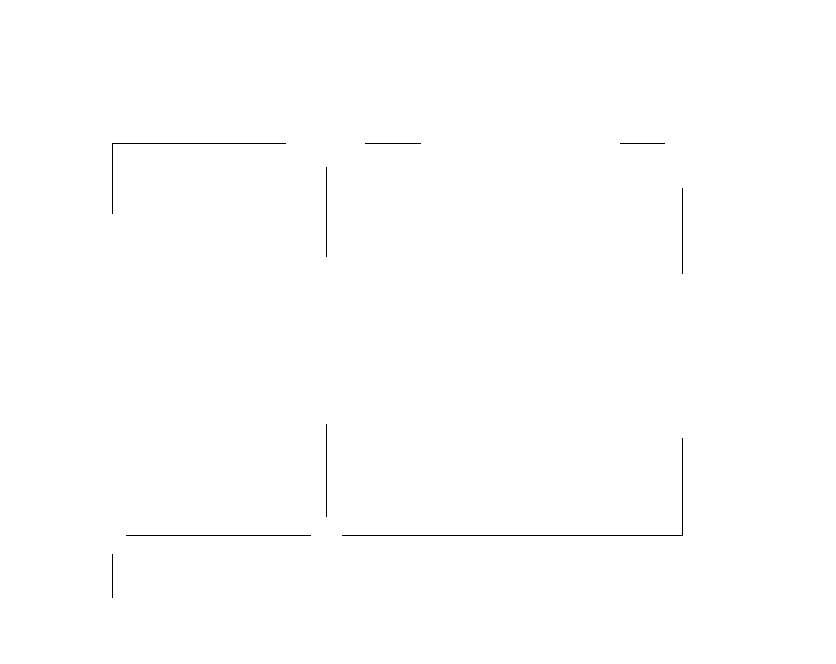

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
img = cv2.imread("/content/14.png")

# Iterate through detections
for box in results[0].boxes:
  # print(box.cls[0])
  # print(box.conf[0])
  x1, y1, x2, y2 = int(box.xyxy[0][0]), int(box.xyxy[0][1]), int(box.xyxy[0][2]), int(box.xyxy[0][3])
  # Get the background color (assuming a static background)
  # Blue color in BGR
  color = (255, 255, 255)
  # Fill the bounding box area with background color
  cv2.rectangle(img, (x1, y1),(x2, y2), color, -1)

  # Save the modified image
cv2.imwrite("/content/test_13_modified.png", img)

# Or display the modified image (press any key to quit)
cv2_imshow(img)

In [ ]:
im2 = cv2.imread('/content/test_13_modified.png')
im2.shape

(664, 836, 3)

# find connection

In [ ]:
!pip install numba imutils

In [ ]:
import numpy as np
import cv2
from numba import njit

def _thinningIteration(im, iter):
    I, M = im, np.zeros(im.shape, np.uint8)

    @njit
    def thinning_iter(I, M, iter):
        for i in range(1, I.shape[0] - 1):
            for j in range(1, I.shape[1] - 1):
                p2 = I[i - 1, j]
                p3 = I[i - 1, j + 1]
                p4 = I[i, j + 1]
                p5 = I[i + 1, j + 1]
                p6 = I[i + 1, j]
                p7 = I[i + 1, j - 1]
                p8 = I[i, j - 1]
                p9 = I[i - 1, j - 1]

                A = (p2 == 0 and p3 == 1) + (p3 == 0 and p4 == 1) + \
                    (p4 == 0 and p5 == 1) + (p5 == 0 and p6 == 1) + \
                    (p6 == 0 and p7 == 1) + (p7 == 0 and p8 == 1) + \
                    (p8 == 0 and p9 == 1) + (p9 == 0 and p2 == 1)

                B = p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9

                if iter == 0:
                    m1 = p2 * p4 * p6
                    m2 = p4 * p6 * p8
                else:
                    m1 = p2 * p4 * p8
                    m2 = p2 * p6 * p8

                if A == 1 and 2 <= B <= 6 and m1 == 0 and m2 == 0:
                    M[i, j] = 1

        return M

    M = thinning_iter(I, M, iter)
    return (I & ~M)

def thinning(src):
    dst = src.copy() // 255
    prev = np.zeros(src.shape[:2], np.uint8)

    while True:
        dst = _thinningIteration(dst, 0)
        dst = _thinningIteration(dst, 1)
        diff = np.abs(dst - prev)
        prev = dst.copy()
        if np.sum(diff) == 0:
            break

    return dst * 255

def skeleton_endpoints(skel):
    # make out input nice, possibly necessary
    skel = skel.copy()
    skel[skel != 0] = 1
    skel = np.uint8(skel)

    # apply the convolution
    kernel = np.uint8([[1,  1, 1],
                       [1, 10, 1],
                       [1,  1, 1]])

    filtered = cv2.filter2D(skel, -1, kernel)

    out = np.zeros_like(skel)
    out[np.where(filtered == 11)] = 255
    return out


In [ ]:
def neighbors(bin_img, x, y):
    """Get all valid neighbors of a point in 8 directions"""
    h, w = bin_img.shape
    deltas = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    for dx, dy in deltas:
        nx, ny = x + dx, y + dy
        if 0 <= nx < h and 0 <= ny < w and bin_img[nx, ny]:
            yield nx, ny


In [ ]:
def trace_node(bin_img, visited, x, y):
    """Trace a single node"""
    stack = [(x, y)]
    node = []
    while stack:
        cx, cy = stack.pop()
        if visited[cx, cy]:
            continue
        visited[cx, cy] = True
        node.append((cx, cy))
        for nx, ny in neighbors(bin_img, cx, cy):
            if not visited[nx, ny]:
                stack.append((nx, ny))
    return node


In [ ]:
def find_all_nodes(bin_img):
    """Find all connected node components"""
    visited = np.zeros_like(bin_img, dtype=bool)
    nodes = []
    for i in range(bin_img.shape[0]):
        for j in range(bin_img.shape[1]):
            if bin_img[i, j] and not visited[i, j]:
                node = trace_node(bin_img, visited, i, j)
                nodes.append(node)
    return nodes


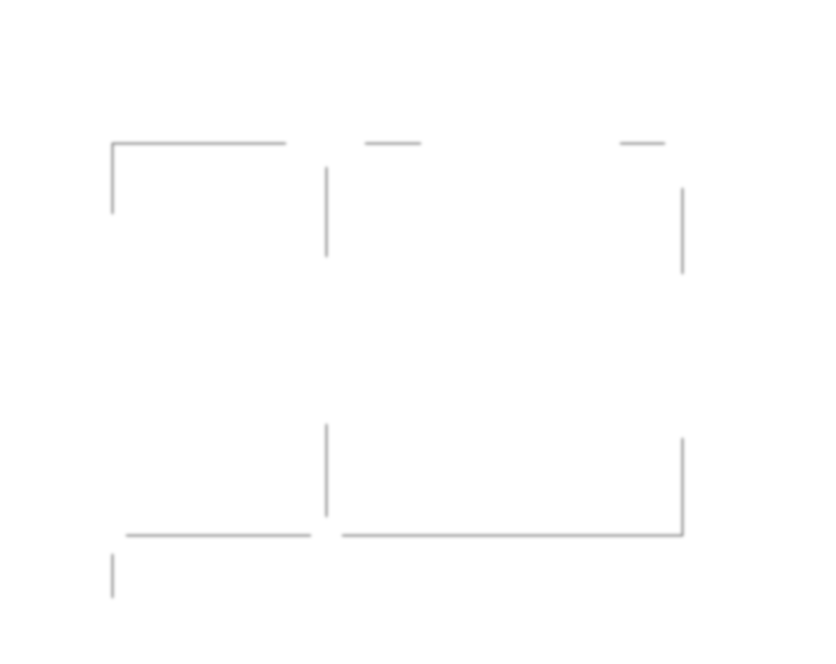

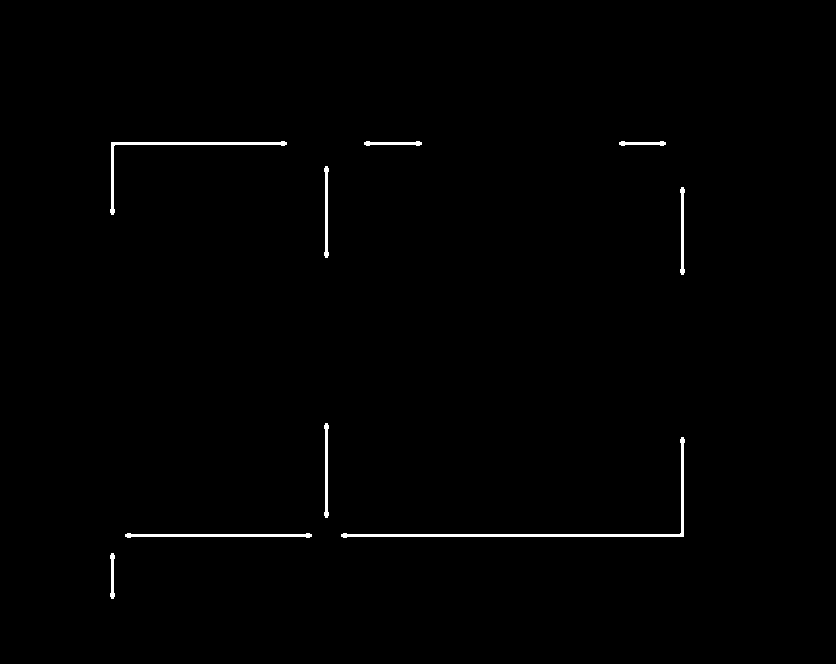

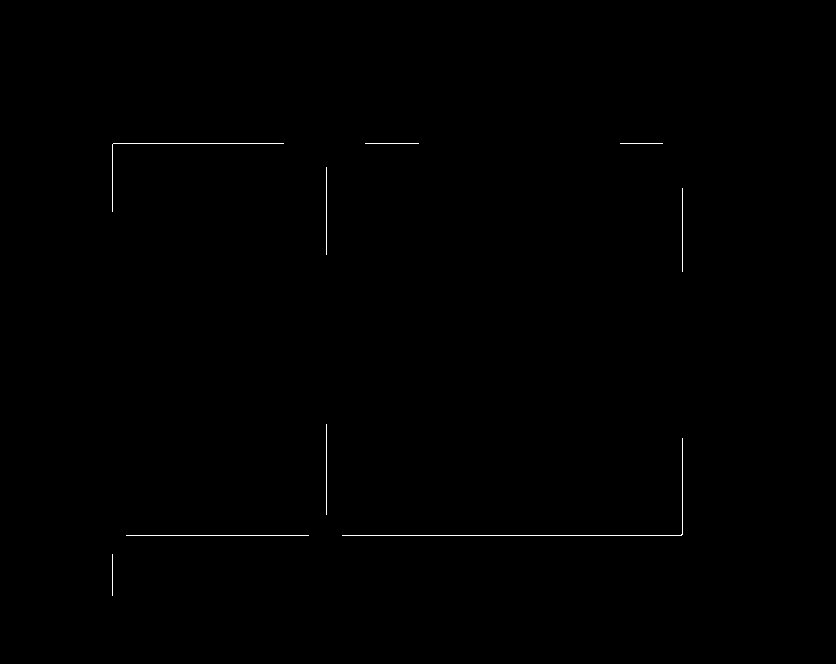

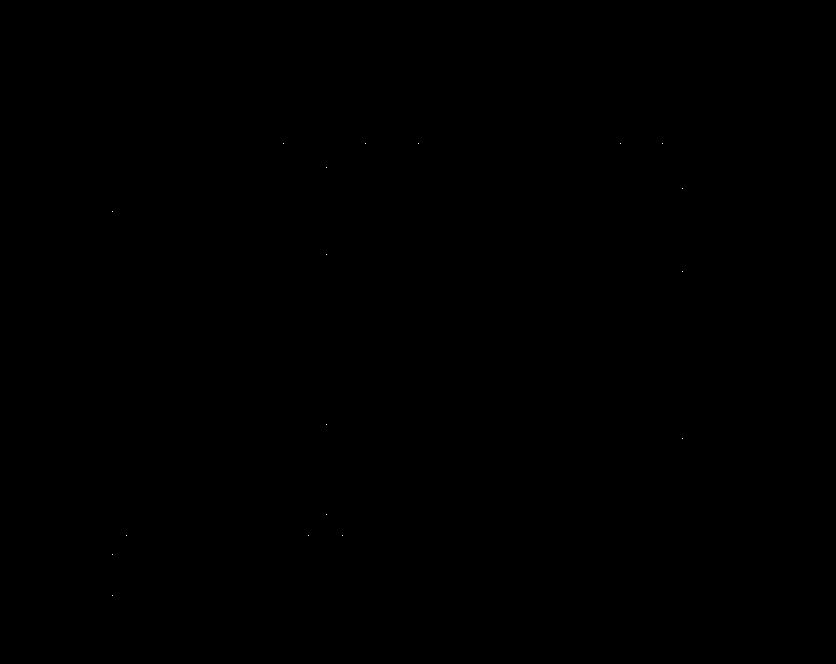

(664, 836)


In [ ]:
import imutils
src = cv2.imread("/content/test_13_modified.png")
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

img = cv2.GaussianBlur(gray,(9,9),0)
cv2_imshow(img)
th = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    cv2.THRESH_BINARY_INV,11,2)
cv2_imshow(th)
bw = thinning(th)
cv2_imshow(bw)
ends = skeleton_endpoints(bw)
cv2_imshow(ends)
print(ends.shape)

# group node

In [ ]:
node = find_all_nodes(bw)
for i in node:
  print(i)

[(143, 113), (144, 112), (145, 112), (146, 112), (147, 112), (148, 112), (149, 112), (150, 112), (151, 112), (152, 112), (153, 112), (154, 112), (155, 112), (156, 112), (157, 112), (158, 112), (159, 112), (160, 112), (161, 112), (162, 112), (163, 112), (164, 112), (165, 112), (166, 112), (167, 112), (168, 112), (169, 112), (170, 112), (171, 112), (172, 112), (173, 112), (174, 112), (175, 112), (176, 112), (177, 112), (178, 112), (179, 112), (180, 112), (181, 112), (182, 112), (183, 112), (184, 112), (185, 112), (186, 112), (187, 112), (188, 112), (189, 112), (190, 112), (191, 112), (192, 112), (193, 112), (194, 112), (195, 112), (196, 112), (197, 112), (198, 112), (199, 112), (200, 112), (201, 112), (202, 112), (203, 112), (204, 112), (205, 112), (206, 112), (207, 112), (208, 112), (209, 112), (210, 112), (211, 112), (143, 114), (143, 115), (143, 116), (143, 117), (143, 118), (143, 119), (143, 120), (143, 121), (143, 122), (143, 123), (143, 124), (143, 125), (143, 126), (143, 127), (14

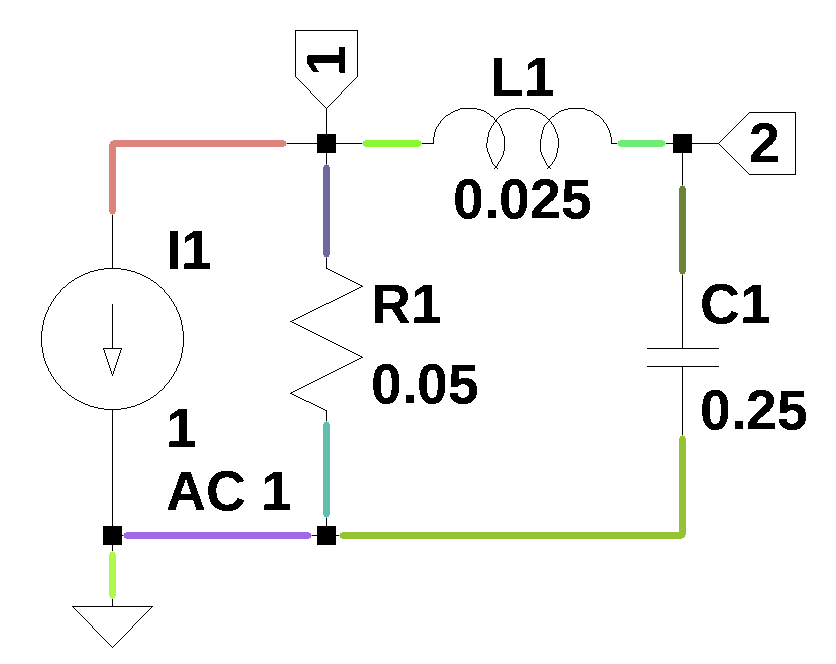

In [ ]:
import cv2
import numpy as np
import random

def visualize_nodes_on_original(bin_img, orig_img, nodes):
    """
    Visualize the nodes with different colors and overlay them on the original image.
    Args:
        bin_img: Binary image (only the circuit lines remain, 1 = line, 0 = background).
        orig_img: Original image (BGR format).
        nodes: List of nodes, where each node is a list of pixel coordinates (x, y).
    Returns:
        Original image with nodes displayed in random colors.
    """
    # Copy the original image for visualization
    overlay_img = orig_img.copy()

    # Generate random colors for each node
    colors = [
        (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))
        for _ in range(len(nodes))
    ]

    # Draw each node on the original image with random colors
    for i, node in enumerate(nodes):
        for x, y in node:
            cv2.circle(overlay_img, (y, x), 3, colors[i], -1)  # Use (y, x) for (col, row)

    return overlay_img


# Find all nodes (use functions from earlier)
nodes = find_all_nodes(bw)

# Load the original image (Ensure it's the same size as binary image)
orig_img = cv2.imread("/content/14.png")  # Replace with the actual file path
# orig_img = cv2.resize(orig_img, (bw.shape[1], bw.shape[0]))  # Resize to match binary image

# Visualize nodes on the original image
result_img = visualize_nodes_on_original(bw, orig_img, nodes)

# Save or display the result
cv2.imwrite("nodes_overlay_on_original.png", result_img)
cv2_imshow(result_img)


In [ ]:
for i, node in enumerate(nodes):
  print(i)
  print(node)

0
[(143, 113), (144, 112), (145, 112), (146, 112), (147, 112), (148, 112), (149, 112), (150, 112), (151, 112), (152, 112), (153, 112), (154, 112), (155, 112), (156, 112), (157, 112), (158, 112), (159, 112), (160, 112), (161, 112), (162, 112), (163, 112), (164, 112), (165, 112), (166, 112), (167, 112), (168, 112), (169, 112), (170, 112), (171, 112), (172, 112), (173, 112), (174, 112), (175, 112), (176, 112), (177, 112), (178, 112), (179, 112), (180, 112), (181, 112), (182, 112), (183, 112), (184, 112), (185, 112), (186, 112), (187, 112), (188, 112), (189, 112), (190, 112), (191, 112), (192, 112), (193, 112), (194, 112), (195, 112), (196, 112), (197, 112), (198, 112), (199, 112), (200, 112), (201, 112), (202, 112), (203, 112), (204, 112), (205, 112), (206, 112), (207, 112), (208, 112), (209, 112), (210, 112), (211, 112), (143, 114), (143, 115), (143, 116), (143, 117), (143, 118), (143, 119), (143, 120), (143, 121), (143, 122), (143, 123), (143, 124), (143, 125), (143, 126), (143, 127), (

# check connection between node and element

In [ ]:
import cv2
import numpy as np
import json
from ultralytics import YOLO

def find_connected_nodes(element_box, nodes, margin=10):
    """
    Find nodes connected to an element based on bounding box overlap with added margin.
    Args:
        element_box: List [x1, y1, x2, y2] for the bounding box of the element.
        nodes: List of nodes, where each node is a list of pixel coordinates (x, y).
        margin: Integer, the margin (in pixels) to expand the bounding box for checking overlap.
    Returns:
        List of connected node indices.
    """
    connected_nodes = []
    x1, y1, x2, y2 = element_box  # Element bounding box coordinates

    # Expand the bounding box with margin
    x_min = x1 - margin
    y_min = y1 - margin
    x_max = x2 + margin
    y_max = y2 + margin

    for i, node in enumerate(nodes):
        # Check if any pixel of the node is within the expanded bounding box
        for ny, nx in node:
            if x_min <= nx <= x_max and y_min <= ny <= y_max:
                connected_nodes.append(i)  # Add node index to connected nodes
                break  # Move to the next node if one match is found

    return connected_nodes


image = cv2.imread("./test_13.png")



# Extract detected elements
elements = []
for result in results:
    for box in results[0].boxes:
  # print(box.cls[0])
  # print(box.conf[0])
        x1, y1, x2, y2 = int(box.xyxy[0][0]), int(box.xyxy[0][1]), int(box.xyxy[0][2]), int(box.xyxy[0][3])
        class_id = int(box.cls[0])
        score = float(box.conf[0])
        elements.append({
            "class_id": class_id,
            "score": score,
            "bbox": [x1, y1, x2, y2]
        })


# Match elements with nodes
elements_with_nodes = []
margin = 20  # Add a margin of 20 pixels
for element in elements:
    connected_nodes = find_connected_nodes(element["bbox"], nodes, margin=margin)
    print(f"Element {element['class_id']} connected to nodes: {connected_nodes}")
    element["connected_nodes"] = connected_nodes
    elements_with_nodes.append(element)

# Save results to JSON
output_json = {
    "elements": elements_with_nodes,
    "nodes": len(nodes)  # Total number of nodes
}

with open("./circuit_connections.json", "w") as json_file:
    json.dump(output_json, json_file, indent=4)

print("JSON file saved: circuit_connections.json")


Element 5 connected to nodes: [1, 2]
Element 4 connected to nodes: [0, 7]
Element 0 connected to nodes: [4, 6]
Element 6 connected to nodes: [3, 5]
Element 3 connected to nodes: [8]
Element 11 connected to nodes: [0, 1, 3]
Element 11 connected to nodes: [2, 4]
Element 10 connected to nodes: [5, 6, 7]
Element 10 connected to nodes: [7, 8]
JSON file saved: circuit_connections.json


In [ ]:
import cv2
import numpy as np
import json
from ultralytics import YOLO


# Mapping class IDs to circuit elements
CLASS_MAP = {0: 'C',
             1: 'CCCS',
             2: 'CCVS',
             3: 'GND',
             4: 'I',
             5: 'L',
             6: 'R',
             7: 'V',
             8: 'VCCS',
             9: 'VCVS',
             10: 'junction',
             11: 'node',
             12: 'op amp',
             13: 'spec'}

def find_connected_nodes(element_box, nodes, margin=10):
    """
    Find nodes connected to an element based on bounding box overlap with added margin.
    Args:
        element_box: List [x1, y1, x2, y2] for the bounding box of the element.
        nodes: List of nodes, where each node is a list of pixel coordinates (x, y).
        margin: Integer, the margin (in pixels) to expand the bounding box for checking overlap.
    Returns:
        List of connected node indices.
    """
    connected_nodes = []
    x1, y1, x2, y2 = element_box  # Element bounding box coordinates

    # Expand the bounding box with margin
    x_min = x1 - margin
    y_min = y1 - margin
    x_max = x2 + margin
    y_max = y2 + margin

    for i, node in enumerate(nodes):
        # Check if any pixel of the node is within the expanded bounding box
        for ny, nx in node:
            if x_min <= nx <= x_max and y_min <= ny <= y_max:
                connected_nodes.append(i)  # Add node index to connected nodes
                break  # Move to the next node if one match is found

    return connected_nodes

# Load image
image = cv2.imread("./test_13.png")



# Load a COCO-pretrained YOLO11x model
model = YOLO("/content/drive/MyDrive/circuit_analysis/train_circuit/yolov11x_train4.pt")


# Run inference with the YOLO11n model on the 'bus.jpg' image
results = model("/content/14.png",save = True)

# Extract detected elements
elements = []
for result in results:
    for box in results[0].boxes:
        x1, y1, x2, y2 = int(box.xyxy[0][0]), int(box.xyxy[0][1]), int(box.xyxy[0][2]), int(box.xyxy[0][3])
        class_id = int(box.cls[0])
        score = float(box.conf[0])

        # Map class ID to element name
        element_name = CLASS_MAP.get(class_id, "Unknown")

        elements.append({
            "class_id": class_id,
            "element_name": element_name,
            "score": score,
            "bbox": [x1, y1, x2, y2]
        })

# Match elements with nodes
elements_with_nodes = []
margin = 20  # Margin for node detection
for element in elements:
    connected_nodes = find_connected_nodes(element["bbox"], nodes, margin=margin)
    print(f"Element {element['element_name']} connected to nodes: {connected_nodes}")
    element["connected_nodes"] = connected_nodes
    elements_with_nodes.append(element)

# Save results to JSON
output_json = {
    "elements": elements_with_nodes,
    "nodes": len(nodes)
}

with open("./circuit_connections.json", "w") as json_file:
    json.dump(output_json, json_file, indent=4)

print("✅ JSON file saved: circuit_connections.json")



image 1/1 /content/14.png: 512x640 1 C, 1 GND, 1 I, 1 L, 1 R, 2 junctions, 2 nodes, 60.3ms
Speed: 3.4ms preprocess, 60.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict2
Element L connected to nodes: [1, 2]
Element I connected to nodes: [0, 7]
Element C connected to nodes: [4, 6]
Element R connected to nodes: [3, 5]
Element GND connected to nodes: [8]
Element node connected to nodes: [0, 1, 3]
Element node connected to nodes: [2, 4]
Element junction connected to nodes: [5, 6, 7]
Element junction connected to nodes: [7, 8]
✅ JSON file saved: circuit_connections.json


In [ ]:
node = find_all_nodes(bw)

In [ ]:
import json
from collections import defaultdict


import json
# Opening JSON file
f = open('./circuit_connections.json')

# returns JSON object as a dictionary
data = json.load(f)


# Create a dictionary to track element counts
element_count = defaultdict(int)

# Prepare the list to store the edges
edges = []

# Process each element and rename if there are duplicates
for element in data['elements']:
    element_name = element['element_name']
    class_id = element['class_id']
    # Count the occurrences of the element
    element_count[element_name] += 1
    # Generate a new element name if it's a duplicate (e.g., "I_1", "I_2")
    new_element_name = f"{element_name}_{element_count[element_name]}"

    # Add edges for the current element's connected nodes
    for node in element['connected_nodes']:
        edges.append((new_element_name, str(node)))

# Show the generated edges
for edge in edges:
    print(edge)


('L_1', '1')
('L_1', '2')
('I_1', '0')
('I_1', '7')
('C_1', '4')
('C_1', '6')
('R_1', '3')
('R_1', '5')
('GND_1', '8')
('node_1', '0')
('node_1', '1')
('node_1', '3')
('node_2', '2')
('node_2', '4')
('junction_1', '5')
('junction_1', '6')
('junction_1', '7')
('junction_2', '7')
('junction_2', '8')


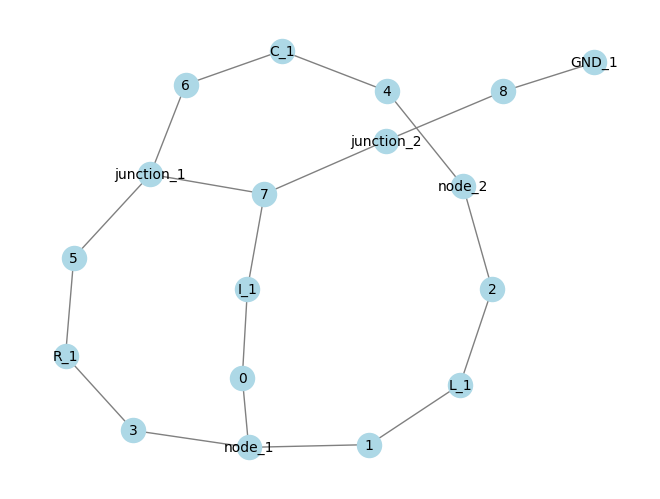

In [ ]:
import networkx as nx

# Mapping class IDs to circuit elements
CLASS_MAP = {
    0: 'C',
    1: 'CCCS',
    2: 'CCVS',
    3: 'GND',
    4: 'I',
    5: 'L',
    6: 'R',
    7: 'V',
    8: 'VCCS',
    9: 'VCVS',
    10: 'junction',
    11: 'node',
    12: 'op amp',
    13: 'spec'
}

# สร้างกราฟเปล่า
G = nx.Graph()

# เพิ่ม edges ที่แปลงจากข้อมูล (ตัวอย่างที่แปลงแล้ว)
edges = edges

# เพิ่ม edges ลงในกราฟ
G.add_edges_from(edges)

import matplotlib.pyplot as plt
pos = nx.spring_layout(G)  # หรือ nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10)
plt.show()


In [ ]:
edges1 = edges

In [ ]:
import networkx as nx

# สร้าง Graph
G = nx.Graph()

# เพิ่ม edges ลงในกราฟ
G.add_edges_from(edges)

# ✅ ตรวจสอบโครงสร้างของกราฟ
print("\n=== Graph Edges ===")
print(G.edges())

# ✅ ใช้ BFS ค้นหาการเชื่อมต่อ โดยหยุดเมื่อพบองค์ประกอบวงจรอื่น ๆ
def bfs_find_nodes(G, start):
    queue = [start]
    visited = set()
    valid_nodes = set()

    while queue:
        node = queue.pop(0)
        if node in visited:
            continue
        visited.add(node)

        # ✅ เช็คว่าถ้าเป็น node_* หรือ GND ให้เพิ่มลงผลลัพธ์
        if 'node_' in node or 'GND' in node:
            valid_nodes.add(node)

        # ✅ หยุดถ้าเจอองค์ประกอบวงจรอื่น
        if any(node.startswith(prefix) for prefix in ['R_', 'L_', 'C_', 'I_']) and node != start:
            continue

        # ✅ ดำเนินการค้นหาต่อ
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                queue.append(neighbor)

    return list(valid_nodes)

# ✅ ตรวจสอบว่าโหนดไหนเชื่อมกับโหนด node_*
def find_element_connections(G):
    connections = {}

    for node in G.nodes():
        # ✅ ตรวจสอบว่าเป็นองค์ประกอบวงจรไฟฟ้าหรือไม่
        if any(node.startswith(prefix) for prefix in ['R_', 'L_', 'C_', 'I_']):
            # ✅ ใช้ BFS หา node ที่เชื่อมต่อโดยตรง
            connected_nodes = bfs_find_nodes(G, node)
            if connected_nodes:
                connections[node] = connected_nodes
                print(f"DEBUG: {node} connected to {connected_nodes}")  # ✅ Debugging

    return connections

# ✅ แสดงผล
element_connections = find_element_connections(G)

print("\n=== Final Connections ===")
for element, nodes in element_connections.items():
    print(f"{element} connected to {nodes}")



=== Graph Edges ===
[('L_1', '1'), ('L_1', '2'), ('1', 'node_1'), ('2', 'node_2'), ('I_1', '0'), ('I_1', '7'), ('0', 'node_1'), ('7', 'junction_1'), ('7', 'junction_2'), ('C_1', '4'), ('C_1', '6'), ('4', 'node_2'), ('6', 'junction_1'), ('R_1', '3'), ('R_1', '5'), ('3', 'node_1'), ('5', 'junction_1'), ('GND_1', '8'), ('8', 'junction_2')]
DEBUG: L_1 connected to ['node_1', 'node_2']
DEBUG: I_1 connected to ['GND_1', 'node_1']
DEBUG: C_1 connected to ['GND_1', 'node_2']
DEBUG: R_1 connected to ['GND_1', 'node_1']

=== Final Connections ===
L_1 connected to ['node_1', 'node_2']
I_1 connected to ['GND_1', 'node_1']
C_1 connected to ['GND_1', 'node_2']
R_1 connected to ['GND_1', 'node_1']


In [ ]:
def generate_netlist(element_connections):
    netlist = []
    element_count = {}

    for element, nodes in element_connections.items():
        # ใช้ตัวนับเพื่อให้ชื่อองค์ประกอบไม่ซ้ำกัน (R1, R2, L1, L2, ...)
        base_name = element.split('_')[0]  # เช่น 'I_1' → 'I'
        element_count[base_name] = element_count.get(base_name, 0) + 1
        element_name = f"{base_name}{element_count[base_name]}"

        # แปลง node_1 → 1, node_2 → 2, ..., GND_1 → 0
        nodes = [node.replace("node_", "") for node in nodes]
        nodes = ["0" if node == "GND_1" else node for node in nodes]

        # ถ้ามีมากกว่า 2 node ให้เลือกเพียง 2 node แรกที่พบ
        if len(nodes) >= 2:
            node1, node2 = nodes[:2]
        elif len(nodes) == 1:
            node1, node2 = nodes[0], "0"  # ถ้ามีแค่ node เดียว กำหนดให้เชื่อมกับ GND (0)
        else:
            continue  # ข้ามถ้าไม่มี node เชื่อมต่อเลย

        netlist.append(f"{element_name} {node1} {node2}")

    return netlist


# ✅ สร้าง Netlist
netlist = generate_netlist(element_connections)

# ✅ แสดงผล
print("\n=== Netlist ===")
for line in netlist:
    print(line)



=== Netlist ===
L1 1 2
I1 0 1
C1 0 2
R1 0 1


In [ ]:
import networkx as nx

# สร้าง Graph
G = nx.Graph()


# ✅ ใช้ BFS ค้นหาการเชื่อมต่อ โดยหยุดเมื่อพบองค์ประกอบวงจรอื่น ๆ
def bfs_find_nodes(G, start):
    queue = [start]
    visited = set()
    valid_nodes = set()

    while queue:
        node = queue.pop(0)
        if node in visited:
            continue
        visited.add(node)

        # ✅ เช็คว่าถ้าเป็น node_* หรือ GND ให้เพิ่มลงผลลัพธ์
        if 'node_' in node or node == 'GND':
            valid_nodes.add(node)

        # ✅ หยุดถ้าเจอองค์ประกอบวงจรอื่น
        if any(node.startswith(prefix) for prefix in ['R_', 'L_', 'C_', 'I_']) and node != start:
            continue

        # ✅ ดำเนินการค้นหาต่อ
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                queue.append(neighbor)

    return list(valid_nodes)

# ✅ ตรวจสอบว่าโหนดไหนเชื่อมกับโหนด node_*
def find_element_connections(G):
    connections = {}

    for node in G.nodes():
        # ✅ ตรวจสอบว่าเป็นองค์ประกอบวงจรไฟฟ้าหรือไม่
        if any(node.startswith(prefix) for prefix in ['R_', 'L_', 'C_', 'I_']):
            # ✅ ใช้ BFS หา node ที่เชื่อมต่อโดยตรง
            connected_nodes = bfs_find_nodes(G, node)
            if connected_nodes:
                connections[node] = connected_nodes

    return connections

# ✅ แสดงผล
element_connections = find_element_connections(G)

print("\n=== Final Connections ===")
for element, nodes in element_connections.items():
    print(f"{element} connected to {nodes}")



=== Final Connections ===


In [ ]:
import cv2
import matplotlib.pyplot as plt
import random

def visualize_connections(image_path, elements, nodes, margin=10):
    """
    Visualize elements, nodes, and their connections on the image.

    Args:
        image_path: Path to the image file.
        elements: List of elements with bounding boxes and connected nodes.
        nodes: List of nodes, where each node is a list of pixel coordinates (x, y).
        margin: Integer, the margin (in pixels) to expand the bounding box for visualization.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Draw elements and bounding boxes
    for element in elements:
        class_id = element["class_id"]
        bbox = element["bbox"]
        connected_nodes = element.get("connected_nodes", [])

        # Bounding box coordinates
        x, y, x2, y2 = bbox
        color = (255, 0, 0)  # Red for element boxes
        cv2.rectangle(image, (x - margin, y - margin), (x2 + margin, y2 + margin), color, 2)

        # Add label for element
        cv2.putText(image, f"Class {class_id}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Calculate the center of the bounding box
        cx = (x + x2) // 2
        cy = (y + y2) // 2

        # Draw lines connecting the element to nodes
        for node_idx in connected_nodes:
            node = nodes[node_idx]
            line_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))  # Random color
            for nx, ny in node:
                cv2.line(image, (cx, cy), (ny, nx), line_color, 2)  # Random colored lines

    # Draw nodes
    for i, node in enumerate(nodes):
        for nx, ny in node:
            cv2.circle(image, (ny, nx), 3, (0, 0, 255), -1)  # Red for nodes
        # Add label for node index
        cv2.putText(image, f"Node {i}", (node[0][1], node[0][0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

    # Show the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


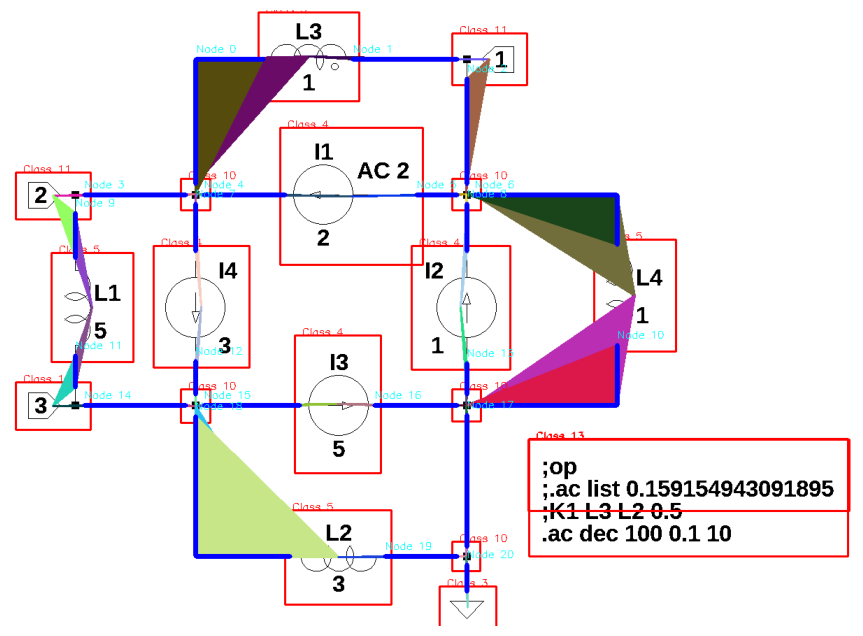

In [ ]:
# Visualize the connections
visualize_connections("/content/test_13.png", elements, nodes, margin=10)

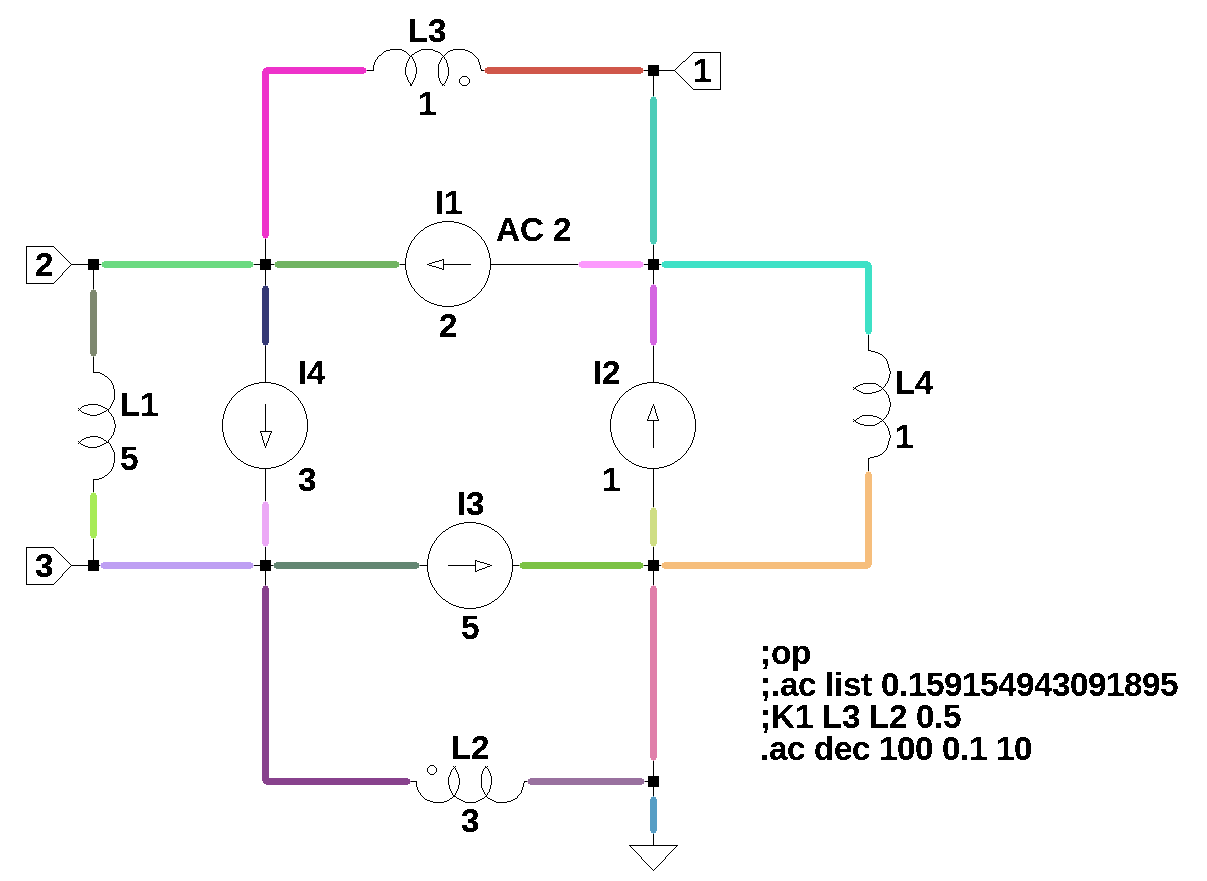

In [ ]:
import cv2
import numpy as np
import random

def visualize_nodes_on_original(bin_img, orig_img, nodes):
    """
    Visualize the nodes with different colors and overlay them on the original image.
    Args:
        bin_img: Binary image (only the circuit lines remain, 1 = line, 0 = background).
        orig_img: Original image (BGR format).
        nodes: List of nodes, where each node is a list of pixel coordinates (x, y).
    Returns:
        Original image with nodes displayed in random colors.
    """
    # Get dimensions of binary and original images
    bin_h, bin_w = bin_img.shape[:2]
    orig_h, orig_w = orig_img.shape[:2]

    # Calculate scaling factors
    scale_x = orig_w / bin_w
    scale_y = orig_h / bin_h

    # Copy the original image for visualization
    overlay_img = orig_img.copy()

    # Generate random colors for each node
    colors = [
        (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))
        for _ in range(len(nodes))
    ]

    # Draw each node on the original image with random colors
    for i, node in enumerate(nodes):
        for x, y in node:
            # Scale the coordinates to match the original image
            scaled_x = int(x * scale_y)
            scaled_y = int(y * scale_x)
            cv2.circle(overlay_img, (scaled_y, scaled_x), 3, colors[i], -1)  # Use (col, row)

    return overlay_img


# Find all nodes (use functions from earlier)
nodes = find_all_nodes(bw)

# Load the original image (Ensure it's the same size as binary image)
orig_img = cv2.imread("/content/test_13.png")  # Replace with the actual file path

# Visualize nodes on the original image
result_img = visualize_nodes_on_original(bw, orig_img, nodes)

# Save or display the result
cv2.imwrite("nodes_overlay_on_original_scaled.png", result_img)
cv2_imshow(result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
